# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Tasklist 15: Session 15: Regularization in MLR. The Maximum Likelihood Estimation (MLE).

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

### Intro 

The goal of this task list is to consolidate our knowledge of the theoretical and practical insights provided on regularization in session 15. So far, we have shown two types of regularization, namely Ridge and Lasso. Also, we did introduce another type of parameter estimation called Maximum Likelihood Estimation. We said that after making the assumption that errors are normally distributed, we can use MLE for linear regression model parameter estimation instead of good old OLS.

Today you are going to do some practicing with the data set provided. This is not the first time you will see this data set. We used it in session 03. It is the Boston Housing Data Set (available from GitHub [here](https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv)).

As a refreshed, here is the list of variables and their description:
- **crim**: per capita crime rate by town.

- **zn**: proportion of residential land zoned for lots over 25,000 sq.ft.

- **indus**: proportion of non-retail business acres per town.

- **chas**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- **nox**: nitrogen oxides concentration (parts per 10 million).

- **rm**: average number of rooms per dwelling.

- **age**: proportion of owner-occupied units built prior to 1940.

- **dis**: weighted mean of distances to five Boston employment centres.

- **rad**: index of accessibility to radial highways.

- **tax**: full-value property-tax rate per \$10,000.

- **ptratio**: pupil-teacher ratio by town.

- **b**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

- **lstat**: lower status of the population (percent).

- **medv**: median value of owner-occupied homes in \$1000s.

Variable **medv** will be the one we are going to predict using Multiple Linear Regression with or without regularization.

Let's start by importing neccessary libraries.

In [1]:

import warnings

warnings.filterwarnings("ignore")

In [2]:
import os 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats 

from statsmodels.regression.linear_model import RegressionResultsWrapper

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

Like we said, we have the data set in `_data` folder.

In [3]:
import os
work_dir = os.getcwd()
data_dir = os.path.join(work_dir, "_data")
os.listdir(data_dir)

['BostonHousingData.csv', 'iris.csv', 'kc_house_data.csv']

Before we go any further, we will define helper methods for easier preview of model performance analysis. It is not necessary to understand the code for the following two methods at hand in order to proceed with the tasks.

In [4]:
# define a method that will return metrics for plotting influential points
def get_influential_points_summary(model: RegressionResultsWrapper, k: int = 1):
    model_inf = model.get_influence()
    # inf_frame = model_inf.summary_frame()
    # w_cookD = np.argwhere(model_inf.cooks_distance[0] > 1)
    n = len(model.resid)
    # w_leverage = np.argwhere(model_inf.hat_matrix_diag > 2*(k+1)/n)

    inf_plot_frame = pd.DataFrame(columns=['Residuals', 'Leverage', 'Cook Dist.'])

    inf_plot_frame['Residuals'] = model.resid
    inf_plot_frame['Leverage'] = model_inf.hat_matrix_diag
    inf_plot_frame['Cook Dist.'] = model_inf.cooks_distance[0]

    return inf_plot_frame

In [5]:
# define method to plot model performance analyis
def plot_model_analysis(model: RegressionResultsWrapper, target) -> None:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    fig.subplots_adjust(hspace=0.4, wspace=.4)
    
    axes = axes.flatten()

    sns.histplot(model.resid, element='step', linewidth=.0, ax=axes[0]);
    sns.despine()
    # axes[0].grid(alpha=.3)
    axes[0].set_title('Residuals hisogram', fontsize=10)
    

    sm.qqplot(model.resid, line='q', ax=axes[1])
    sns.despine()
    axes[1].set_title('Q-Q Plot of model residuals', fontsize=10)
    
    ip_summary = get_influential_points_summary(model)
    
    sns.scatterplot(data=ip_summary, x='Leverage', y='Residuals', size='Cook Dist.', hue=(ip_summary['Cook Dist.'] > 1), legend=None, ax=axes[2])
    sns.despine()
    axes[2].set_title("Influence Plot\n Size of the blob corresponds to Cook's distance", fontsize=10);

    sns.scatterplot(x=target, y=model.resid, s=10, ax=axes[3])
    sns.despine()
    axes[3].axhline(y=0, color='red')
    axes[3].grid(alpha=.4)
    axes[3].set_title('Price vs Residual', fontsize=10)
    axes[3].set_xlabel('price')
    axes[3].set_ylabel('residuals')

    sns.scatterplot(x=target, y=model.predict(), s=10, ax=axes[4])
    sns.despine()
    axes[4].axline((0, 0), (1, 1), color='red')
    axes[4].grid(alpha=.4)
    axes[4].set_title('Price vs Predicted', fontsize=10)
    axes[4].set_xlabel('price')
    axes[4].set_ylabel('predicted')

    sns.scatterplot(x=target, y=model.resid/target, s=10, ax=axes[5])
    sns.despine()
    axes[5].axhline(y=0, color='red')
    axes[5].grid(alpha=.4)
    axes[5].set_title('Price vs residual/price', fontsize=10)
    axes[5].set_xlabel('price')
    axes[5].set_ylabel('residual/price (%)')

    fig.suptitle('Model analysis', fontsize=15)

## Regularization

**01.** Load the data set and do the initial scan of the data set.

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'BostonHousingData.csv'))

In [7]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


**02.** Are there any missing values?

In [9]:
df.isna().sum(axis=0)

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

**03.** Perform the EDA on data set provided.

In [10]:
df.select_dtypes(exclude='object').describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


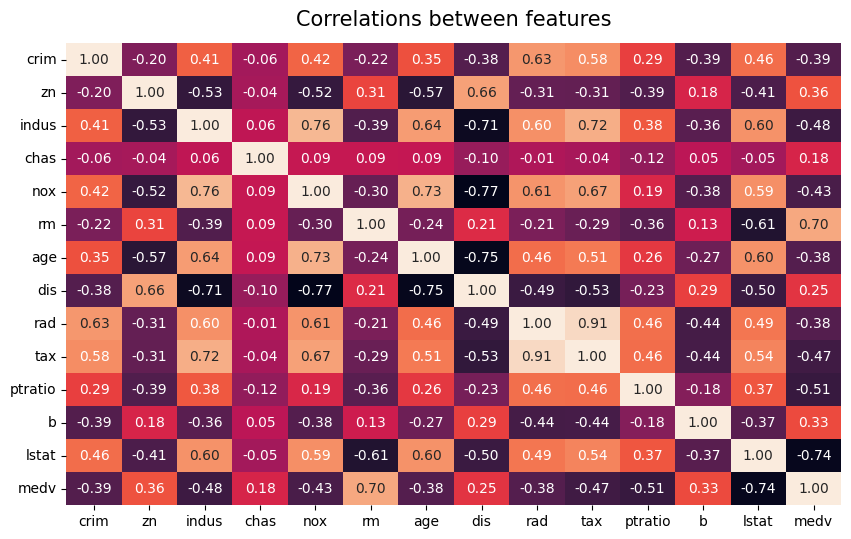

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=df.corr(), fmt='.2f', annot=True, cbar=False)
plt.title('Correlations between features', size=15, y=1.02);

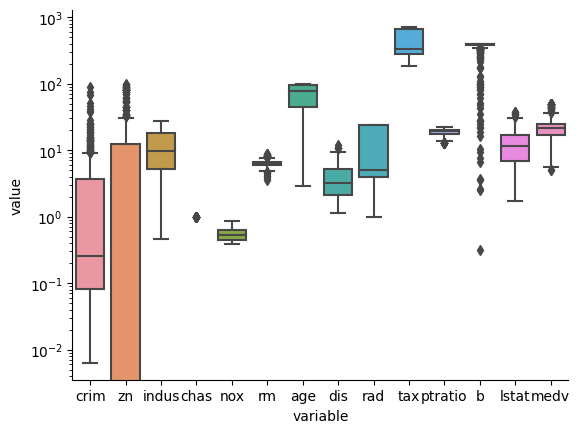

In [12]:
sns.boxplot(x='variable', y='value', data=df.melt())
sns.despine()
plt.yscale('log')

In [13]:
df['chas'].value_counts()

0    471
1     35
Name: chas, dtype: int64

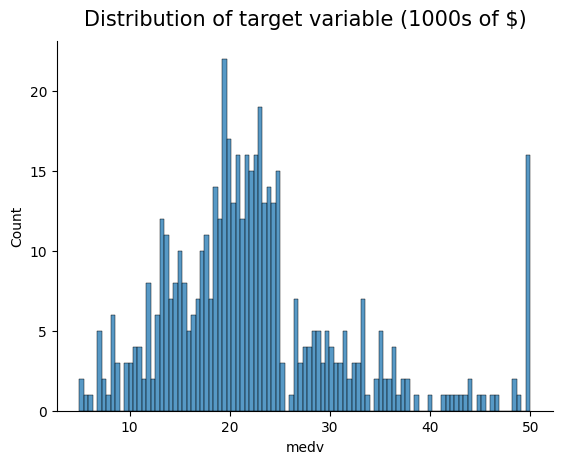

In [14]:
sns.histplot(df['medv'], bins=101)
sns.despine()
plt.title('Distribution of target variable (1000s of $)', size=15, y=1.02);

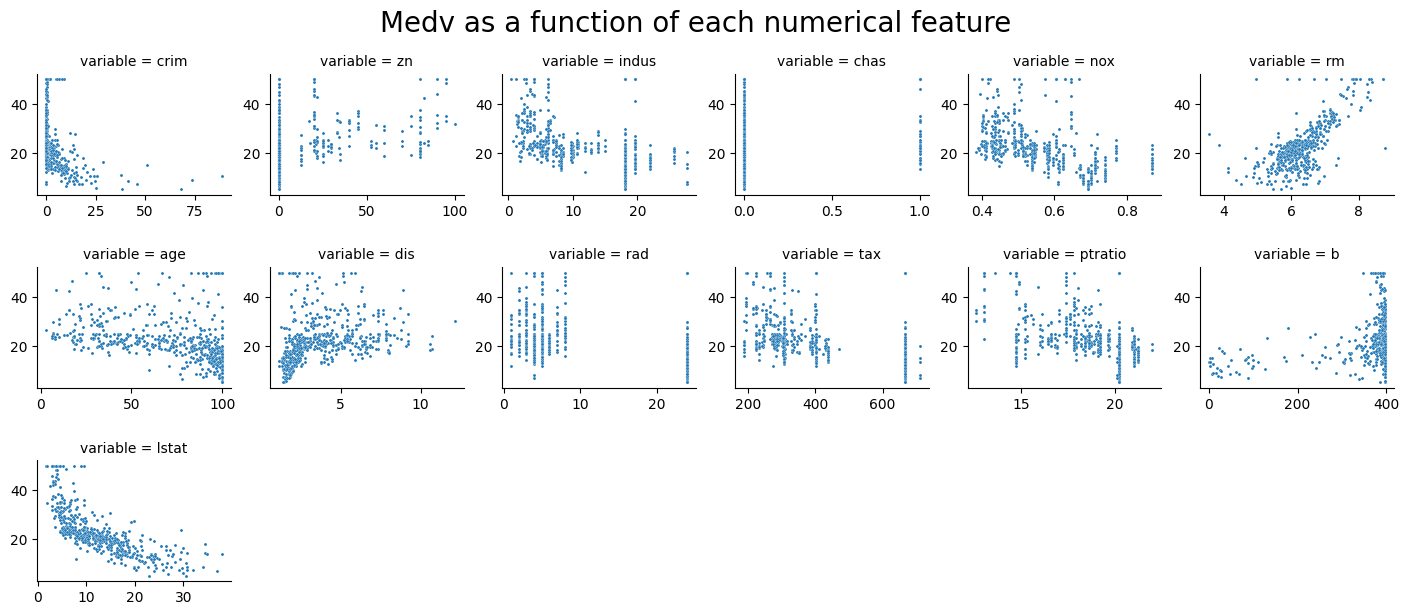

In [15]:
_df = df.melt(id_vars='medv')

g = sns.FacetGrid(data=_df,  col='variable', col_wrap=6, sharey=False, sharex=False, height=2, aspect=1.2)
g.map(sns.scatterplot, 'value', 'medv', s=5)
g.figure.subplots_adjust(wspace=.2, hspace=.6)
g.set_xlabels("")
g.set_ylabels("")
plt.gcf().suptitle('Medv as a function of each numerical feature', size=20, y=1.05);


**04.** We talked about certain assumptions that have to be fulfilled before using linear models (MLR). What can you conclude by now?

We can see there is an indication of high multicolinearity in this data set. There are pairs of variables with absolute correlation above .7, and one pair with very high correlation, .91, between `tax` and `rad`.

**05.** Use `statsmodels` to fit the MLR model. 

In [16]:
X_train, y_train = df.drop(columns=['medv']), df['medv']

In [17]:
formula = 'medv ~ ' + ' + '.join([str(i) for i in X_train.columns.to_list()])

formula

'medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + b + lstat'

In [18]:
mlr = smf.ols(formula=formula, data=df).fit()

mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 06 May 2023   Prob (F-statistic):          6.72e-135
Time:                        08:09:36   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.000      26.432      46.487
crim          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
zn             0.0464      0.014      3.382      0.001       0.019       0.073
indus          0.0206      0.061      0.334      0.738      -0.100       0.141
chas           2.6867      0.862      3.118      0.002       0.994       4.380
nox          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
rm             3.8099      0.418      9.116      0.000       2.989       4.631
age            0.0007      0.013      0.052      0.958      -0.025       0.027
dis           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
rad            0.3060      0.066      4.613      0.000       0.176       0.436
tax           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
ptratio       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
b              0.0093      0.003      3.467      0.001       0.004       0.015
lstat         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**06.** What are your conclusions based on the results of `statsmodels` model report?

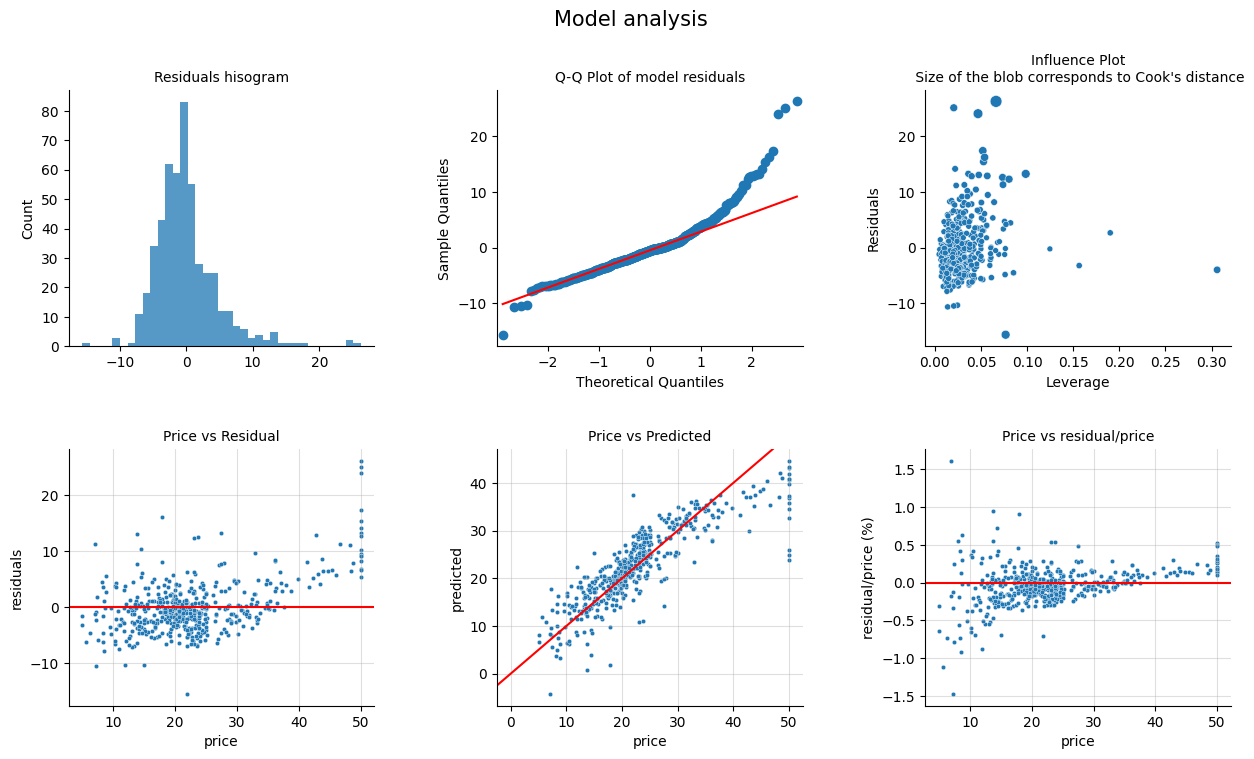

In [19]:
plot_model_analysis(mlr, y_train)

Residuals look strange. They are not normally distributed. What is even stranger are some strange residuals as we can see on lower 3 charts. It seems that homoskedastisicy assumption is not holding.

**07.** What are the *VIF*s for each predictor variable? What are your conclusions?

In [20]:
predictors = X_train.columns

model_frame_predictors = sm.add_constant(X_train)

vifs = [variance_inflation_factor(model_frame_predictors.values, i) for i in range(1, len(predictors)+1)]
vifs = np.array(vifs).reshape(1, -1)
vifs

pd.DataFrame(vifs, columns=predictors).T.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})

,VIF
tax,9.008554
rad,7.484496
nox,4.393720
indus,3.991596
dis,3.955945
age,3.100826
lstat,2.941491
zn,2.298758
rm,1.933744
ptratio,1.799084


`tax` and `rad` VIFs is very high. This goes along with their correlation that we have seen previously in EDA.

**08.** Use `sklearn` **Ridge** regularized linear model and search for the best `alpha` value, like we did in session 15. 

In [21]:
### --- Varying the penalization parameter for the Ridge Regularized Model
n_alphas = 200
alphas = np.logspace(-3, 10, n_alphas)

coefs = []
scores = []
mserrs = []
l2_norms = []
for a in alphas:
    # - fitting a Ridge Regularization
    ridge = linear_model.Ridge(alpha=a, normalize=True)
    ridge.fit(X_train, y_train)
    
    # - R^2 score of a fitted Regularized Model
    R2 = ridge.score(X_train, y_train)
    
    # - MSE of a model
    mse = np.mean((y_train - ridge.predict(X_train))**2)
    
    # - squared L2 norm of model coefficients
    l2 = np.linalg.norm(ridge.coef_, ord=2)**2
    
    coefs.append(ridge.coef_)
    scores.append(R2)
    mserrs.append(mse)
    l2_norms.append(l2)

**09.** Plot how different *alpha* values affect: model parameters, L2 norm, MSE and R2 scores. What are your conclusions based on the charts?

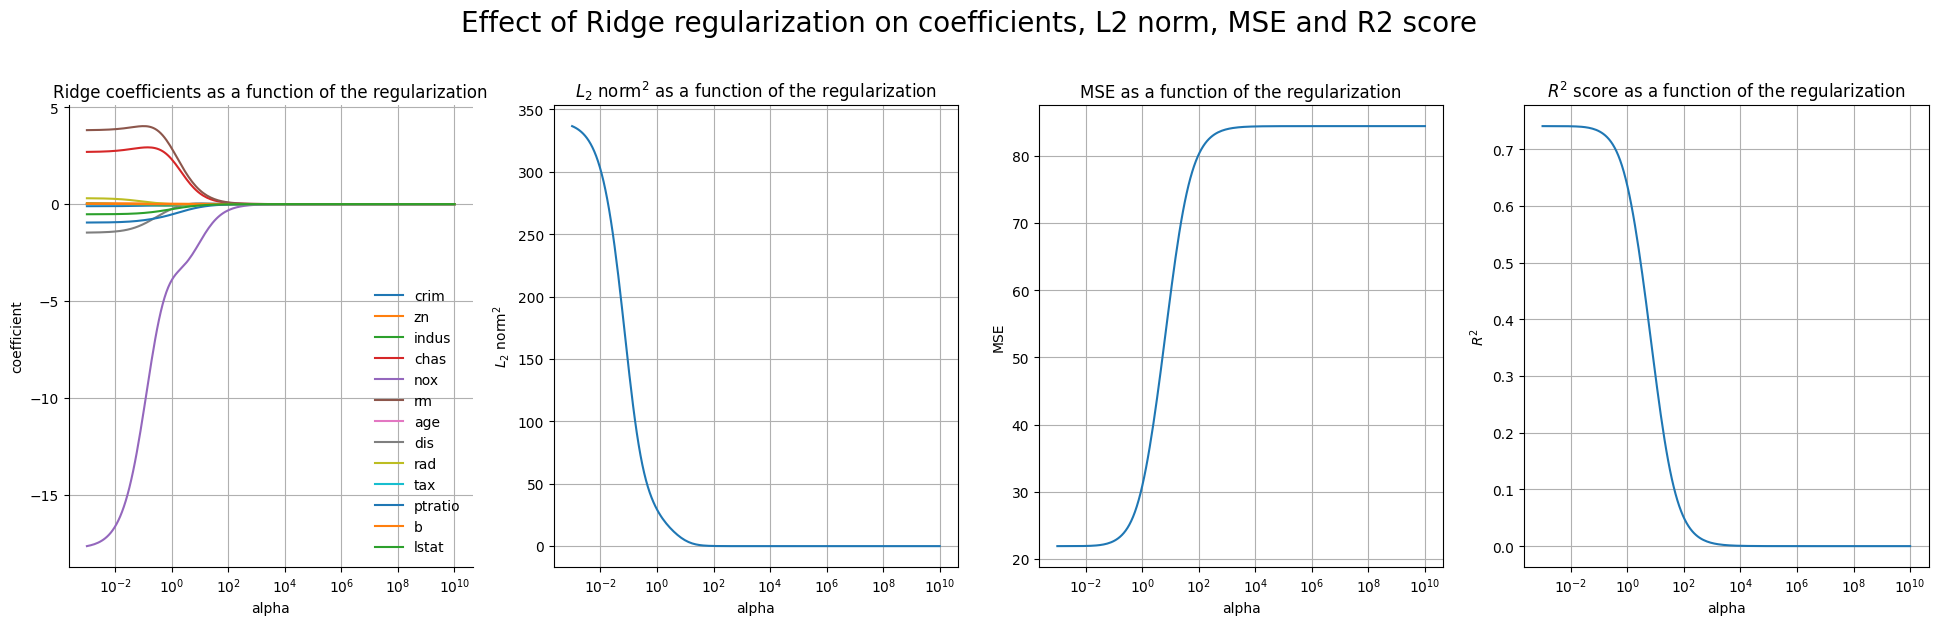

In [22]:
## --- Plotting the dependance of various model metrics vs. the penalization hyperparameter
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True)

ax[0].plot(alphas, coefs)
ax[0].set_xscale("log")
ax[0].set_xlim(ax[0].get_xlim())  # reverse axis
sns.despine(ax=ax[0])
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("coefficient")
ax[0].set_title("Ridge coefficients as a function of the regularization")
ax[0].axis("tight")
ax[0].legend(predictors, frameon=False)
ax[0].grid()

# - squared L2-norm vs. \alpha
ax[1].plot(alphas, l2_norms)
ax[1].set_xscale("log")
ax[1].set_xlim(ax[0].get_xlim())  # reverse axis

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("$L_2$ norm$^2$")
ax[1].set_title("$L_2$ norm$^2$ as a function of the regularization")
ax[1].axis("tight")
ax[1].grid()

# - MSE vs. \alpha
ax[2].plot(alphas, mserrs)
ax[2].set_xscale("log")
ax[2].set_xlabel("alpha")
ax[2].set_ylabel("MSE")
ax[2].set_title("MSE as a function of the regularization")
ax[2].axis("tight")
ax[2].grid()

# - R^2 vs. \alpha
ax[3].plot(alphas, scores)
ax[3].set_xscale("log")
ax[3].set_xlabel("alpha")
ax[3].set_ylabel("$R^2$")
ax[3].set_title("$R^2$ score as a function of the regularization")
ax[3].axis("tight")
ax[3].grid();

fig.suptitle('Effect of Ridge regularization on coefficients, L2 norm, MSE and R2 score', size=20, y=1.04);

Apparently this model is underfitting and regularizing using Ridge will not help in increasing it's performance. At least, we do not see this from these plots.

**10.** Use `sklearn` **Lasso** regularized linear model and search for the best `alpha` value, like we did in session 15. 

In [23]:
### --- Varying the penalization parameter for the Ridge Regularized Model
n_alphas = 200
alphas = np.logspace(-3, 10, n_alphas)

coefs = []
scores = []
mserrs = []
l2_norms = []
for a in alphas:
    # - fitting a Ridge Regularization
    ridge = linear_model.Lasso(alpha=a, normalize=True)
    ridge.fit(X_train, y_train)
    
    # - R^2 score of a fitted Regularized Model
    R2 = ridge.score(X_train, y_train)
    
    # - MSE of a model
    mse = np.mean((y_train - ridge.predict(X_train))**2)
    
    # - squared L2 norm of model coefficients
    l2 = np.linalg.norm(ridge.coef_, ord=2)**2
    
    coefs.append(ridge.coef_)
    scores.append(R2)
    mserrs.append(mse)
    l2_norms.append(l2)

**11.** Plot how different *alpha* values affect: model parameters, L2 norm, MSE and R2 scores. What are your conclusions based on the charts?

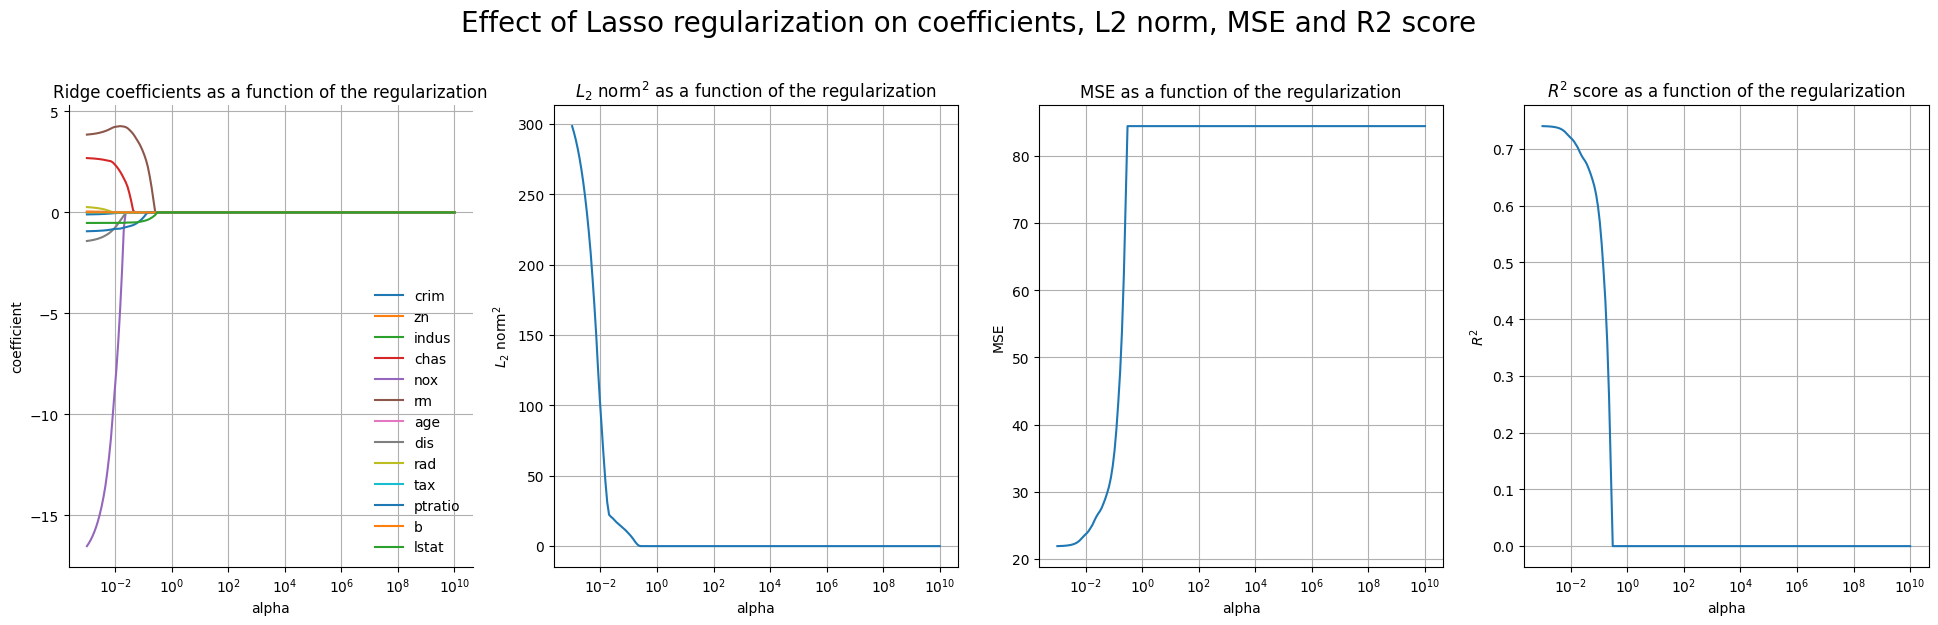

In [24]:
## --- Plotting the dependance of various model metrics vs. the penalization hyperparameter
fig, ax = plt.subplots(1, 4, figsize=(24, 6), sharex=True)

ax[0].plot(alphas, coefs)
ax[0].set_xscale("log")
ax[0].set_xlim(ax[0].get_xlim())  # reverse axis
sns.despine(ax=ax[0])
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("coefficient")
ax[0].set_title("Ridge coefficients as a function of the regularization")
ax[0].axis("tight")
ax[0].legend(predictors, frameon=False)
ax[0].grid()

# - squared L2-norm vs. \alpha
ax[1].plot(alphas, l2_norms)
ax[1].set_xscale("log")
ax[1].set_xlim(ax[0].get_xlim())  # reverse axis

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("$L_2$ norm$^2$")
ax[1].set_title("$L_2$ norm$^2$ as a function of the regularization")
ax[1].axis("tight")
ax[1].grid()

# - MSE vs. \alpha
ax[2].plot(alphas, mserrs)
ax[2].set_xscale("log")
ax[2].set_xlabel("alpha")
ax[2].set_ylabel("MSE")
ax[2].set_title("MSE as a function of the regularization")
ax[2].axis("tight")
ax[2].grid()

# - R^2 vs. \alpha
ax[3].plot(alphas, scores)
ax[3].set_xscale("log")
ax[3].set_xlabel("alpha")
ax[3].set_ylabel("$R^2$")
ax[3].set_title("$R^2$ score as a function of the regularization")
ax[3].axis("tight")
ax[3].grid();

fig.suptitle('Effect of Lasso regularization on coefficients, L2 norm, MSE and R2 score', size=20, y=1.04);

Apparently this model is underfitting and regularizing using Lasso will not help in increasing it's performance. 

At least, we do not see this from these plots.

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>